# Goal

It has been shown that [quantum computers can be identified by biases in their results](https://collapsedwave.com/%F0%9F%97%92%EF%B8%8F-Papers/%F0%9F%97%92%EF%B8%8F-Learning-the-noise-fingerprint-of-quantum-devices). In this notebook we aim to build a Quantum Computer identifier, i.e. a predictor that based on the input algorithm and the probability distribution of the results, returns the machine it has likely been built on.

# Notation

- $a \in A$ is an algorithm: A quantum algorithm / quantum circuit.
- $C \in \Omega$ is a Quantum Computer: One of the machines available to run algorithms on
- $C_a$ is the true probability distribution of running the algorithm $a$ on the quantum computer $C$.
- $T: C_a \mapsto C$ is our Predictor: A model that maps outputs of a quantum algorithm run on a quantum computer, to the likelihood of which quantum computer it ran on. 

# Setup

## Inputs

- We need to be able to map a generic algorithm to an input in our predictor

## Predictor

- We can add / remove quantum computers to our predictor without having to retrain everything
- The predictor returns a weighted array of quantum machine likelihoods
- Since the output is a probability distribution, we have:
    - Access to the simulated output as the unbiased probability distribution
    - Distance metrics between probability distributions that allow us to represent consistent biases in the calculations.
- We might be able to represent the dag as THE neural network, and each computer has their own gate mapping that is initialized as the true gate, however we learn the gate's noise as a computer $C$ specific gate. This way the learning problem generalises to generic DAGs. Asking then for the true quantum computer is a question of feeding forward through each Computer specific DAG, and checking the expected output likelihoods. This requires us to be able to run through the DAG in a classical computer, which means that we are limited to small enough DAGs. Not a problem?

## Loss function

- We want our loss function to be a Proper Scoring Rule, meaning that $\mathbb{E}[L(\mu)]$ is minimized when the forecaster outputs the true distribution $\mu$ of the underlying distribution we are trying to predict.


# Code

## Imports

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService

## Create an algorithm

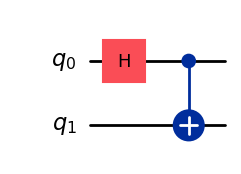

In [2]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw("mpl")

## Run an algorithm on IBM



In [7]:
# Set up six different observables.
observables_labels = ["ZZ", "ZI", "IZ", "XX", "XI"]
observables = [SparsePauliOp(label) for label in observables_labels]

In [10]:
service = QiskitRuntimeService(channel="ibm_quantum", token=token)
backend = service.least_busy(simulator=False, operational=True)
estimator = Estimator(backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 10

In [11]:
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)


In [12]:
observables = [observable.apply_layout(isa_circuit.layout) for observable in observables]

In [13]:
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, observables)])

In [14]:
# This is the result of the entire submission.  We submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()

In [15]:
# This is the result from our single pub, which had five observables,
# so contains information on all five.
pub_result = job.result()[0]

In [16]:
job_result

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(5,), dtype=float64>), stds=np.ndarray(<shape=(5,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(5,), dtype=float64>)), metadata={'shots': 64, 'target_precision': 0.31622776601683794, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 1})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})

In [17]:
pub_result

PubResult(data=DataBin(evs=np.ndarray(<shape=(5,), dtype=float64>), stds=np.ndarray(<shape=(5,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(5,), dtype=float64>)), metadata={'shots': 64, 'target_precision': 0.31622776601683794, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 1})

In [18]:
channel="ibm_quantum"

pub_result

PubResult(data=DataBin(evs=np.ndarray(<shape=(5,), dtype=float64>), stds=np.ndarray(<shape=(5,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(5,), dtype=float64>)), metadata={'shots': 64, 'target_precision': 0.31622776601683794, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 1})